In [27]:
#* trans the data to the test
import pandas as pd
import glob
from tqdm import tqdm
import csv
import torchio as tio

names_list = []
with open('D:\Work_file\det\csv_file\\train_test_names.csv') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    for row in reader:
        names_list.append(row[0])

In [28]:
for name in tqdm(names_list):
    
    data = pd.read_csv('D:\Work_file\det\\annotations_resmaple_segcrop_guanfang.csv')
    want_data = data[data.iloc[:, 0] == name]
    image = tio.ScalarImage(f'D:\Work_file\det\data_seg_crop\\{name}_croplung.nii.gz')
    shape = image.shape[1:]
    
    with open(f'D:\Work_file\Object-Detection-Metrics-3D\samples\sample_2\\train_groundtruths\\{name}.txt', 'w') as f:
        for index, row in want_data.iterrows():
            xin = row[1]
            yin = row[2]
            zin = row[3]
            w   = row[4]
            h   = row[5]
            d   = row[6]
            x1  = xin - w / 2.0 
            y1  = yin - h / 2.0
            z1  = zin - d / 2.0
            x2  = xin + w / 2.0
            y2  = yin + h / 2.0
            z2  = zin + d / 2.0
            f.write(f'nodule {x1} {y1} {z1} {x2} {y2} {z2} {shape}\n')


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:08<00:00, 11.35it/s]


In [2]:
import numpy as np
import torch


def sliding_window_3d_volume_padded(arr, patch_size=128, stride=1, padding_value=0):
    """
    This function takes a 3D numpy array representing a 3D volume and returns a 4D array of patches extracted using a sliding window approach.
    The input array is padded to ensure that its dimensions are divisible by the patch size.
    :param arr: 3D numpy array representing a 3D volume
    :param patch_size: size of the cubic patches to be extracted
    :param stride: stride of the sliding window
    :param padding_value: value to use for padding
    :return: 4D numpy array of shape (num_patches, patch_size, patch_size, patch_size)
    """
    # regular the shape
    if len(arr.shape) != 3:
        arr = arr.squeeze(0)

    # Compute the padding size for each dimension
    pad_size_x = (patch_size - (arr.shape[0] % patch_size)) % patch_size
    pad_size_y = (patch_size - (arr.shape[1] % patch_size)) % patch_size
    pad_size_z = (patch_size - (arr.shape[2] % patch_size)) % patch_size

    # Pad the array
    arr_padded = np.pad(arr, ((0, pad_size_x), (0, pad_size_y), (0, pad_size_z)), mode='constant', constant_values=padding_value)

    # Extract patches using a sliding window approach
    patches = []
    order = 0
    for i in range(0, arr_padded.shape[0] - patch_size + 1, stride):
        for j in range(0, arr_padded.shape[1] - patch_size + 1, stride):
            for k in range(0, arr_padded.shape[2] - patch_size + 1, stride):
                patch = arr_padded[i:i + patch_size, j:j + patch_size, k:k + patch_size]
                if isinstance(patch, np.ndarray):
                    patch = torch.from_numpy(patch).unsqueeze(0)
                else:
                    patch = patch.unsqueeze(0)
                start_point = torch.tensor([order, i, j, k])
                add = {'image': patch, 'point': start_point}
                patches.append(add)
                order += 1
    return np.array(patches)



d:\Anaconda_location\envs\det\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
shape = (10, 10, 10)
arr = np.empty(shape, dtype='U9')

for i in range(shape[0]):
    for j in range(shape[1]):
        for k in range(shape[2]):
            arr[i, j, k] = f"{i:03}{j:03}{k:03}"
arr = np.array(arr, dtype=int)
print(arr[5, 5, 1])

5005001


In [14]:
patches = sliding_window_3d_volume_padded(arr, patch_size=4, stride=2, padding_value=0)
print(patches[0]['image'][0][3, 3, 3])
print(patches[0]['point'])
print(patches[1]['image'][0][3, 3, 3])
print(patches[1]['point'])
print(patches[2]['image'][0][3, 3, 3])
print(patches[2]['point'])
print(patches[3]['image'][0][3, 3, 3])
print(patches[3]['point'])

tensor(3003003, dtype=torch.int32)
tensor([0, 0, 0, 0])
tensor(3003005, dtype=torch.int32)
tensor([1, 0, 0, 2])
tensor(3003007, dtype=torch.int32)
tensor([2, 0, 0, 4])
tensor(3003009, dtype=torch.int32)
tensor([3, 0, 0, 6])


87


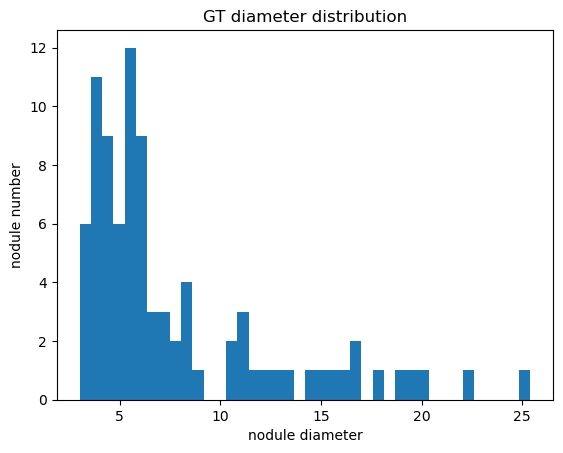

In [36]:
import csv 
import pandas as pd
import matplotlib.pyplot as plt

test_names = []
with open('D:\Work_file\det\csv_file\\test_names_server.csv') as file:
    reader = csv.reader(file)
    next(reader)
    for row in reader:
        test_names.append(row[0])
    
# print(test_names)
df = pd.read_csv('D:\Work_file\det\\annotations_resmaple_segcrop_guanfang.csv')
dias = []
for name in test_names:
    # print(f'the name is {df.iloc[:, 0]}')
    filter_df = df[df.iloc[:, 0] == name]
    # print(filter_df)
    # print('=========================================')
    # print(filter_df.iloc[:, 3])
    dias.extend(filter_df.iloc[:, 4].astype(float).tolist())
    # print(f'the dias is {dias}')
print(len(dias))
plt.hist(dias, bins=40)
plt.title('GT diameter distribution')
plt.xlabel('nodule diameter')
plt.ylabel('nodule number')
plt.show()

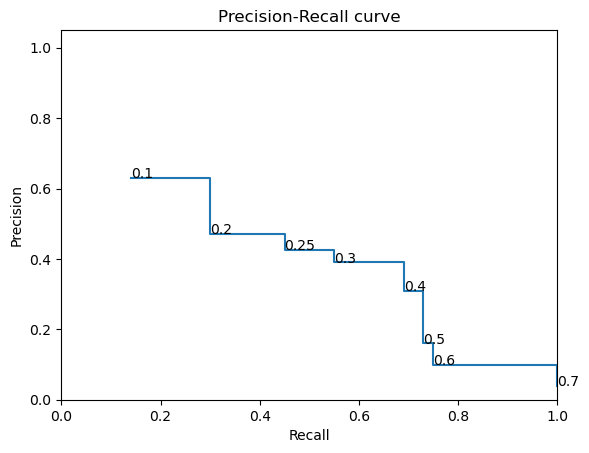

In [40]:
import matplotlib.pyplot as plt

x = [0.14, 0.3, 0.45, 0.55, 0.69, 0.73, 0.75, 1]
y = [0.63, 0.47, 0.425, 0.39, 0.31, 0.16, 0.1, 0.04]
labels = [0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7]

plt.step(x, y, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve')

# 在每个点上添加指定的文本信息
for i in range(len(x)):
    plt.annotate(f'{labels[i]}', (x[i], y[i]))

plt.show()




In [43]:
import random

x1 = random.randint(0, 0)
print(x1)

0


In [9]:
# def non_overlapping_boxes(boxes):
#     non_overlapping = []
#     for i, box1 in enumerate(boxes):
#         overlapping = False
#         for j, box2 in enumerate(boxes):
#             if i != j:
#                 if boxes_overlap(box1, box2):
#                     # print(boxes_overlap(box1, box2))
#                     # print(f'the box1 is {box1}, the box2 is {box2}')
#                     overlapping = True
#                     if box_area(box1) > box_area(box2):
#                         # print('begin the box_area')
#                         # print(f'the box_area1 is {box_area(box1)}')
#                         # print(f'the box_area2 is {box_area(box2)}')
#                         # non_overlapping.append(box1)
#                         non_overlapping[j] = box1
#                         # print(overlapping)
#                         # print(non_overlapping)
#                     break
#         if not overlapping:
#             non_overlapping.append(box1)
#             # print(overlapping)
#             # print(non_overlapping)
#     return non_overlapping



def non_overlapping_boxes(boxes):
    non_overlapping = []
    for i, box1 in enumerate(boxes):
        overlapping = False
        if box1 == []:
            continue
        for j, box2 in enumerate(non_overlapping):

            if boxes_overlap(box1, box2):
                overlapping = True
                if box_area(box1) > box_area(box2):
                    non_overlapping.remove(box2)
                    non_overlapping.append(box1)
                break
        if not overlapping:
            non_overlapping.append(box1)
    return non_overlapping

def boxes_overlap(box1, box2):
    x1, y1, z1, x2, y2, z2 = [np.float16(x) for x in box1]
    a1, b1, c1, a2, b2, c2 = [np.float16(x) for x in box2]
    return not (x2 < a1 or a2 < x1 or y2 < b1 or b2 < y1 or z2 < c1 or c2 < z1)

def box_area(box):
    x1, y1, z1, x2, y2, z2 = box
    return (x2 - x1) * (y2 - y1) * (z2 - z1)


if __name__ == '__main__':
    import numpy as np
    # boxes = [
    #     [58.16192626953125 , 156.14132690429688, 109.94187927246094, 64.9867935180664, 162.956222534179,  117.1567382812],
    #     [58.316490173339844, 156.2911987304687,  111.1626586914062,  64.810691833496,  162.793624877929,  117.8324890136],
    #     [58.16055679321289 , 157.10047912597656, 109.91998291015625, 64.9437026977539, 163.8703002929687, 117.0694274902],
    #     [58.362579345703125, 157.3153991699218,  111.1372222900390,  64.807350158691,  163.759963989257,  117.8814544677],
    #     [58.581626892089844, 157.5279235839843,  112.5815658569336,  64.5024261474609, 163.472747802734,  118.3229751586],
    #     [58.59052658081055 , 157.6197052001953 , 113.5241928100586,  64.5068435668945, 163.5554962158203, 119.4906845092],
    #     [58.90037155151367 , 157.09225463867188, 109.78683471679688, 65.8479080200195, 163.999893188476,  117.1656188964],
    #     [59.28178787231445 , 157.3961639404297 , 111.33416748046875, 65.6282501220703, 163.7189331054687, 117.6537322998],
    # ]

    # boxes = [
    #     [71.38176727294922,  104.38442993164062,  91.197517395019, 77.911109924316, 110.9055786132812, 97.8871688842773],
    #     [71.6317367553711 , 103.78858947753906 , 89.1251525878906, 79.3459548950195, 111.4352264404296, 97.840087890625],
    #     [72.47953033447266,  104.59605407714844,  91.44775390625 , 78.60230255126953 , 110.73008728027344 , 97.56912231],
    #     [72.38211822509766,  105.32945251464844,  91.417549133300, 78.518608093261, 111.502532958984,    97.46202850341],
    #     [306.5187683105469,  215.5235595703125 , 150.962768554687, 314.552673339843, 223.453140258789, 160.24771118164 ],
    #     ]

    boxes =  [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [[0.4782, 373.1783, 125.2339, 80.8881, 379.8865, 131.9055, 88.1457], [0.4782, 375.1783, 124.2339, 82.8881, 378.8865, 133.9055, 88.1457]], [], [], [], [], []]


    non_overlapping = non_overlapping_boxes(boxes)
    print(non_overlapping)

[[[0.4782, 373.1783, 125.2339, 80.8881, 379.8865, 131.9055, 88.1457], [0.4782, 375.1783, 124.2339, 82.8881, 378.8865, 133.9055, 88.1457]]]


In [11]:
def normal_list(list):
    new_list = []
    for lit in list:
        if lit == []:
            continue
        else:
            for l in lit:
                new_list.append(l)
    return new_list

if __name__ == '__main__':

    boxes =  [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [[0.4782, 373.1783, 125.2339, 80.8881, 379.8865, 131.9055, 88.1457], [0.4782, 375.1783, 124.2339, 82.8881, 378.8865, 133.9055, 88.1457]], [], [], [], [], []]
    new_list = normal_list(boxes)
    print(new_list)

[[0.4782, 373.1783, 125.2339, 80.8881, 379.8865, 131.9055, 88.1457], [0.4782, 375.1783, 124.2339, 82.8881, 378.8865, 133.9055, 88.1457]]


In [18]:
def filter_boxes(gt, pred):
    result = []
    for box in gt:
        overlap = False
        for p_box in pred:
            if (box[0] < p_box[4] and box[3] > p_box[1]) and (box[1] < p_box[5] and box[4] > p_box[2]) and (box[2] < p_box[6] and box[5] > p_box[3]):
                overlap = True
                break
        if not overlap:
            result.append(min(box[3]-box[0], box[4]-box[1], box[5]-box[2]))
    return result

if __name__ == '__main__':
    gt =  [[98.05825912622767, 42.70620981194197, 106.61561743075758, 101.95211821662944, 46.60006890234376, 113.59341273590913], 
           [102.22428197578128, 62.26858603292413, 106.53775104054424, 107.56967176707593, 67.61397582421877, 116.11668929278903], 
           [128.0582083512277, 255.55760759408477, 112.17424015245363, 134.0738653344866, 261.5732645773437, 122.95429718087964], 
           [117.85603062678571, 271.3506521410714, 116.80039675067417, 130.2426500017857, 283.7372715160714, 138.9972180826592], 
           [120.63162457070314, 46.423108827846015, 122.87526191843259, 126.06359048643975, 51.85507474358263, 132.60934458156746]]
    pred =  [[0.3026, 123.9272, 45.3096, 121.4670, 130.5316, 51.8747, 129.3292], 
             [0.4782, 118.9985, 274.8981, 125.6276, 126.0990, 281.9443, 133.4238], 
             [0.4782, 255.6902, 99.7333, 146.1966, 263.3732, 107.3580, 154.7685]]
    result = filter_boxes(gt, pred)
    print(result)
    result.extend([ ])
    print(result)
    result.extend([1])
    print(result)

[3.893859090401776, 5.345389791294643, 6.015656983258907]
[3.893859090401776, 5.345389791294643, 6.015656983258907]
[3.893859090401776, 5.345389791294643, 6.015656983258907, 1]


In [6]:
from ensemble_boxes import *

boxes_list = [[
    [0.00, 0.51, 0.81, 0.91],
    [0.10, 0.31, 0.71, 0.61],
    [0.01, 0.32, 0.83, 0.93],
    [0.02, 0.53, 0.11, 0.94],
    [0.03, 0.24, 0.12, 0.35],
],[
    [0.04, 0.56, 0.84, 0.92],
    [0.12, 0.33, 0.72, 0.64],
    [0.38, 0.66, 0.79, 0.95],
    [0.08, 0.49, 0.21, 0.89],
]]
scores_list = [[0.9, 0.8, 0.2, 0.4, 0.7], [0.5, 0.8, 0.7, 0.3]]
labels_list = [[0, 1, 0, 1, 1], [1, 1, 1, 0]]
weights = [2, 1]

iou_thr = 0.5
skip_box_thr = 0.0001
sigma = 0.1

boxes, scores, labels = nms(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr)
print('=========')
print(boxes, '=====', scores, labels)
boxes, scores, labels = soft_nms(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr, sigma=sigma, thresh=skip_box_thr)
print('=========')
print(boxes, '=====', scores, labels)
boxes, scores, labels = non_maximum_weighted(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
print('=========')
print(boxes, '=====', scores, labels)
boxes, scores, labels = weighted_boxes_fusion(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
print('=========')
print(boxes, '=====', scores, labels)

[[0.   0.51 0.81 0.91]
 [0.08 0.49 0.21 0.89]
 [0.1  0.31 0.71 0.61]
 [0.03 0.24 0.12 0.35]
 [0.02 0.53 0.11 0.94]
 [0.38 0.66 0.79 0.95]
 [0.04 0.56 0.84 0.92]] ===== [0.6        0.1        0.53333333 0.46666667 0.26666667 0.23333333
 0.16666667] [0 0 1 1 1 1 1]
[[0.   0.51 0.81 0.91]
 [0.08 0.49 0.21 0.89]
 [0.01 0.32 0.83 0.93]
 [0.1  0.31 0.71 0.61]
 [0.03 0.24 0.12 0.35]
 [0.02 0.53 0.11 0.94]
 [0.38 0.66 0.79 0.95]
 [0.04 0.56 0.84 0.92]
 [0.12 0.33 0.72 0.64]] ===== [0.4        0.03333333 0.08888889 0.35555556 0.31111111 0.17777778
 0.07777778 0.05555556 0.08888889] [0 0 0 1 1 1 1 1 1]
[[0.00123605 0.48651513 0.8124721  0.91247207]
 [0.10184006 0.31184006 0.71092004 0.61276007]
 [0.03       0.23999998 0.11999999 0.35      ]
 [0.02       0.53000003 0.11       0.94      ]
 [0.38       0.65999997 0.78999996 0.95      ]
 [0.04       0.56       0.84       0.91999996]
 [0.08       0.49       0.21       0.8899999 ]] ===== [0.4        0.35555556 0.31111112 0.17777778 0.03888889 0.027777

In [ ]:
def nms(dets, thres):
    '''
    https://github.com/rbgirshick/py-faster-rcnn/blob/master/lib/nms/py_cpu_nms.py
    :param dets:  [[x1,y1,x2,y2,score], [x1,y1,x2,y2,score],,,]
    :param thres: for example 0.5
    :return: the rest ids of dets
    '''
    x1 = [det[1] for det in dets]
    y1 = [det[2] for det in dets]
    z1 = [det[3] for det in dets]
    x2 = [det[4] for det in dets]
    y2 = [det[5] for det in dets]
    z2 = [det[6] for det in dets]
    areas = [(x2[i] - x1[i]) * (y2[i] - y1[i]) * (z2[i] - z1[i]) for i in range(len(x1))]
    scores = [det[0] for det in dets]
    order = order = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)

    keep = []
    while len(order) > 0:
        i = order[0]
        keep.append(i)
        xx1 = [max(x1[i], x1[j]) for j in order[1:]]
        xx2 = [min(x2[i], x2[j]) for j in order[1:]]
        yy1 = [max(y1[i], y1[j]) for j in order[1:]]
        yy2 = [min(y2[i], y2[j]) for j in order[1:]]
        zz1 = [max(z1[i], z1[j]) for j in order[1:]]
        zz2 = [min(z2[i], z2[j]) for j in order[1:]]
        w = [max(xx2[i] - xx1[i], 0.0) for i in range(len(xx1))]
        h = [max(yy2[i] - yy1[i], 0.0) for i in range(len(yy1))]
        d = [max(zz2[i] - zz1[i], 0.0) for i in range(len(zz1))]

        inters = [w[i] * h[i] * d[i] for i in range(len(w))]
        unis = [areas[i] + areas[j] - inters[k] for k, j in enumerate(order[1:])]
        ious = [inters[i] / unis[i] for i in range(len(inters))]

        inds = [i for i, val in enumerate(ious) if val <= thres]
         # return the rest boxxes whose iou<=thres

        order = [order[i + 1] for i in inds]

            # inds + 1]  # for exmaple, [1,0,2,3,4] compare '1', the rest is 0,2 who is the id, then oder id is 1,3
        result = [dets[i] for i in keep]

    return result

import numpy as np
# dets =  [[0.3026, 123.9272, 45.3096, 121.4670, 130.5316, 51.8747, 129.3292], 
#          [0.4782, 118.9985, 274.8981, 125.6276, 126.0990, 281.9443, 133.4238], 
#          [0.4782, 255.6902, 99.7333, 146.1966, 263.3732, 107.3580, 154.7685]]
dets = [
    [0.35, 58.16192626953125 , 156.14132690429688, 109.94187927246094, 64.9867935180664, 162.956222534179,  117.1567382812],
    [0.35, 58.316490173339844, 156.2911987304687,  111.1626586914062,  64.810691833496,  162.793624877929,  117.8324890136],
    [0.55, 58.16055679321289 , 157.10047912597656, 109.91998291015625, 64.9437026977539, 163.8703002929687, 117.0694274902],
    [0.75, 58.362579345703125, 157.3153991699218,  111.1372222900390,  64.807350158691,  163.759963989257,  117.8814544677],
    [0.35, 58.581626892089844, 157.5279235839843,  112.5815658569336,  64.5024261474609, 163.472747802734,  118.3229751586],
    [0.35, 58.59052658081055, 157.6197052001953 , 113.5241928100586,  64.5068435668945, 163.5554962158203, 119.4906845092],
    [0.35, 58.90037155151367, 157.09225463867188, 109.78683471679688, 65.8479080200195, 163.999893188476,  117.1656188964],
    [0.85, 59.28178787231445, 157.3961639404297 , 111.33416748046875, 65.6282501220703, 163.7189331054687, 117.6537322998],
    [0.35, 71.38176727294922,  104.38442993164062,  91.197517395019, 77.911109924316, 110.9055786132812, 97.8871688842773],
    [0.35, 71.6317367553711, 103.78858947753906 , 89.1251525878906, 79.3459548950195, 111.4352264404296, 97.840087890625],
    [0.15, 72.47953033447266,  104.59605407714844,  91.44775390625 , 78.60230255126953 , 110.73008728027344 , 97.56912231],
    [0.35, 72.38211822509766,  105.32945251464844,  91.417549133300, 78.518608093261, 111.502532958984,    97.46202850341],
    [0.25, 306.5187683105469,  215.5235595703125 , 150.962768554687, 314.552673339843, 223.453140258789, 160.24771118164 ],
]

thres = 0.5
keep = nms(dets, thres)
print(keep)




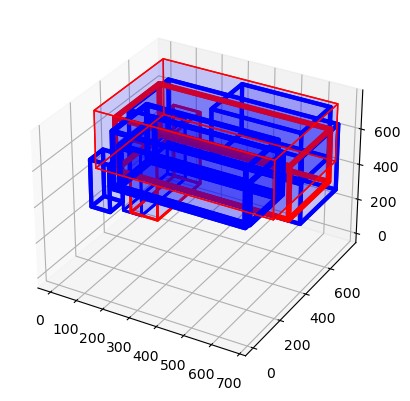

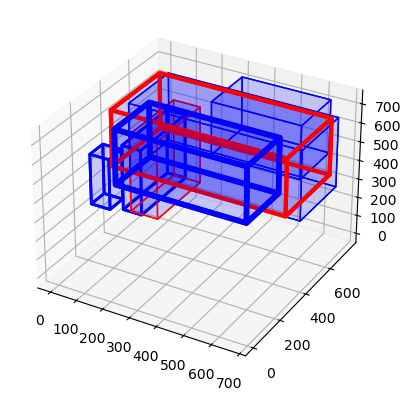

7
[[0.10666665 0.31666666 0.45333335 0.71333331 0.62       0.81666666]
 [0.00181818 0.47545454 0.43545455 0.8136363  0.91363633 0.81090909]
 [0.03       0.24       0.34       0.12       0.35       0.67      ]
 [0.02       0.53       0.11       0.11       0.94       0.55      ]
 [0.38       0.66       0.55       0.79       0.95       0.9       ]
 [0.04       0.56       0.36       0.84       0.92       0.82      ]
 [0.08       0.49       0.15       0.21       0.89       0.67      ]]


In [1]:
# coding: utf-8
__author__ = 'ZFTurbo: https://kaggle.com/zfturbo'


import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from ensemble_boxes import *


def plot_cube(ax, cube_definition, lbl, thickness):
    cube_definition_array = [
        np.array(list(item))
        for item in cube_definition
    ]

    points = []
    points += cube_definition_array
    vectors = [
        cube_definition_array[1] - cube_definition_array[0],
        cube_definition_array[2] - cube_definition_array[0],
        cube_definition_array[3] - cube_definition_array[0]
    ]

    points += [cube_definition_array[0] + vectors[0] + vectors[1]]
    points += [cube_definition_array[0] + vectors[0] + vectors[2]]
    points += [cube_definition_array[0] + vectors[1] + vectors[2]]
    points += [cube_definition_array[0] + vectors[0] + vectors[1] + vectors[2]]

    points = np.array(points)

    edges = [
        [points[0], points[3], points[5], points[1]],
        [points[1], points[5], points[7], points[4]],
        [points[4], points[2], points[6], points[7]],
        [points[2], points[6], points[3], points[0]],
        [points[0], points[2], points[4], points[1]],
        [points[3], points[6], points[7], points[5]]
    ]

    faces = Poly3DCollection(edges, linewidths=thickness + 1)
    if lbl == 0:
        faces.set_edgecolor((1, 0, 0))
    else:
        faces.set_edgecolor((0, 0, 1))
    faces.set_facecolor((0, 0, 1, 0.1))

    ax.add_collection3d(faces)
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=0)


def show_boxes(boxes_list, scores_list, labels_list, image_size=800):
    image = np.zeros((image_size, image_size, 3), dtype=np.uint8)
    image[...] = 255
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for i in range(len(boxes_list)):
        for j in range(len(boxes_list[i])):
            x1 = int(image_size * boxes_list[i][j][0])
            y1 = int(image_size * boxes_list[i][j][1])
            z1 = int(image_size * boxes_list[i][j][2])
            x2 = int(image_size * boxes_list[i][j][3])
            y2 = int(image_size * boxes_list[i][j][4])
            z2 = int(image_size * boxes_list[i][j][5])
            lbl = labels_list[i][j]
            cube_definition = [
                (x1, y1, z1), (x1, y2, z1), (x2, y1, z1), (x1, y1, z2)
            ]
            plot_cube(ax, cube_definition, lbl, int(4 * scores_list[i][j]))

    plt.show()


def example_wbf_3d_2_models(iou_thr=0.55, draw_image=True):
    """
    This example shows how to ensemble boxes from 2 models using WBF_3D method
    :return: 
    """

    boxes_list = [
        [
            [0.00, 0.51, 0.41, 0.81, 0.91, 0.78],
            [0.10, 0.31, 0.45, 0.71, 0.61, 0.85],
            [0.01, 0.32, 0.55, 0.83, 0.93, 0.95],
            [0.02, 0.53, 0.11, 0.11, 0.94, 0.55],
            [0.03, 0.24, 0.34, 0.12, 0.35, 0.67],
        ],
        [
            [0.04, 0.56, 0.36, 0.84, 0.92, 0.82],
            [0.12, 0.33, 0.46, 0.72, 0.64, 0.75],
            [0.38, 0.66, 0.55, 0.79, 0.95, 0.90],
            [0.08, 0.49, 0.15, 0.21, 0.89, 0.67],
        ],
    ]
    scores_list = [
        [
            0.9,
            0.8,
            0.2,
            0.4,
            0.7,
        ],
        [
            0.5,
            0.8,
            0.7,
            0.3,
        ]
    ]
    labels_list = [
        [
            0,
            1,
            0,
            1,
            1,
        ],
        [
            1,
            1,
            1,
            0,
        ]
    ]
    weights = [2, 1]
    if draw_image:
        show_boxes(boxes_list, scores_list, labels_list)

    boxes, scores, labels = weighted_boxes_fusion_3d(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr, skip_box_thr=0.0)

    if draw_image:
        show_boxes([boxes], [scores], [labels.astype(np.int32)])

    print(len(boxes))
    print(boxes)


if __name__ == '__main__':
    draw_image = True
    example_wbf_3d_2_models(iou_thr=0.2, draw_image=draw_image)

In [38]:
import SimpleITK as sitk
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive
from ipywidgets import widgets


def myshow(img, title=None, margin=0.05, dpi=80, cmap="gray"):
    nda = sitk.GetArrayFromImage(img)

    spacing = img.GetSpacing()
    slicer = False

    if nda.ndim == 3:
        # fastest dim, either component or x
        c = nda.shape[-1]

        # the the number of components is 3 or 4 consider it an RGB image
        if not c in (3, 4):
            slicer = True

    elif nda.ndim == 4:
        c = nda.shape[-1]

        if not c in (3, 4):
            raise RuntimeError("Unable to show 3D-vector Image")

        # take a z-slice
        slicer = True

    if slicer:
        ysize = nda.shape[1]
        xsize = nda.shape[2]
    else:
        ysize = nda.shape[0]
        xsize = nda.shape[1]

    # Make a figure big enough to accommodate an axis of xpixels by ypixels
    # as well as the ticklabels, etc...
    figsize = (1 + margin) * ysize / dpi, (1 + margin) * xsize / dpi

    def callback(z=None):
        extent = (0, xsize * spacing[1], ysize * spacing[0], 0)

        fig = plt.figure(figsize=figsize, dpi=dpi)

        # Make the axis the right size...
        ax = fig.add_axes([margin, margin, 1 - 2 * margin, 1 - 2 * margin])

        if z is None:
            ax.imshow(nda, extent=extent, interpolation=None, cmap=cmap)
        else:
            ax.imshow(nda[z, ...], extent=extent, interpolation=None, cmap=cmap)

        if title:
            plt.title(title)

        plt.show()

    if slicer:
        interact(callback, z=(0, nda.shape[0] - 1))
    else:
        callback()


def myshow3d(img, xslices=[], yslices=[], zslices=[], title=None, margin=0.05, dpi=80):
    size = img.GetSize()
    img_xslices = [img[s, :, :] for s in xslices]
    img_yslices = [img[:, s, :] for s in yslices]
    img_zslices = [img[:, :, s] for s in zslices]

    maxlen = max(len(img_xslices), len(img_yslices), len(img_zslices))

    img_null = sitk.Image([0, 0], img.GetPixelID(), img.GetNumberOfComponentsPerPixel())

    img_slices = []
    d = 0

    if len(img_xslices):
        img_slices += img_xslices + [img_null] * (maxlen - len(img_xslices))
        d += 1

    if len(img_yslices):
        img_slices += img_yslices + [img_null] * (maxlen - len(img_yslices))
        d += 1

    if len(img_zslices):
        img_slices += img_zslices + [img_null] * (maxlen - len(img_zslices))
        d += 1

    if maxlen != 0:
        if img.GetNumberOfComponentsPerPixel() == 1:
            img = sitk.Tile(img_slices, [maxlen, d])
        # TODO check in code to get Tile Filter working with VectorImages
        else:
            img_comps = []
            for i in range(0, img.GetNumberOfComponentsPerPixel()):
                img_slices_c = [sitk.VectorIndexSelectionCast(s, i) for s in img_slices]
                img_comps.append(sitk.Tile(img_slices_c, [maxlen, d]))
            img = sitk.Compose(img_comps)

    myshow(img, title, margin, dpi)

In [1]:
import SimpleITK as sitk
import skimage.io as io
# from myshow import myshow, myshow3d

def show_img(data):
    # for i in range(data.shape[0]):
    for i in range(39, 45):
        io.imshow(data[i,:,:], cmap='gray')
        print(i)
        io.show()


img = sitk.ReadImage("C:\\Users\\DELL\\Desktop\\pred_hmap-model_res101v2_crop256_0728.nii")
# data = sitk.GetArrayFromImage(img)

# show_img(data)
# for i in range(data.shape[0]):
# for i in range(38, 45):
#         io.imshow(data[i, :, :], cmap='gray')
#         print(i)
#         io.show()


# myshow3d(img)

In [2]:

sigma=img.GetSpacing()[0]
level=4
# feature_img = sitk.GradientMagnitude(img)

feature_img = sitk.GradientMagnitudeRecursiveGaussian(img, sigma=1.5)
# feature_img = sitk.GetArrayFromImage(feature_img)
# show_img(feature_img)
# myshow(feature_img, "Edge Features")

In [3]:

ws_img = sitk.MorphologicalWatershed(feature_img, level=0.0001, markWatershedLine=False, fullyConnected=True)

seg = sitk.ConnectedComponent(ws_img!=ws_img[0,0, 0])


# ws_img = sitk.GetArrayFromImage(sitk.LabelToRGB(ws_img))
# show_img(ws_img)

# seg = sitk.GetArrayFromImage(sitk.LabelOverlay(img, seg))
# show_img(seg)

In [6]:
filled = sitk.BinaryFillhole(seg!=0)
d = sitk.SignedMaurerDistanceMap(filled, insideIsPositive=False, squaredDistance=False, useImageSpacing=False)
# d = sitk.GetArrayFromImage(d)
# show_img(d)

In [13]:
ws = sitk.MorphologicalWatershed( d, markWatershedLine=False, level=1)
# myshow(sitk.LabelOverlay(img, ws))
# ws = sitk.GetArrayFromImage(sitk.LabelOverlay(img, ws))
# show_img(ws)

In [14]:
ws = sitk.Mask( ws, sitk.Cast(seg, ws.GetPixelID()))
# myshow(sitk.LabelOverlay(img, ws), "Split Objects")
# ws = sitk.GetArrayFromImage(sitk.LabelOverlay(img, ws))
result = sitk.LabelOverlay(img, ws)
# show_img(ws)
sitk.WriteImage(result, 'C:\\Users\\DELL\\Desktop\\result.nii')

In [25]:
import os
files = os.listdir('D:\Work_file\Object-Detection-Metrics-3D\samples\sample_2\detections')
print(len(files))

50


In [ ]:
import matplotlib.pyplot as plt

arrowstyles = ['-', '->', '-[', '|-|', '-|>', '<-', '<->', '<|-', '<|-|>', 'fancy', 'simple', 'wedge']

for i, arrowstyle in enumerate(arrowstyles):
    plt.annotate(arrowstyle, xy=(0.5, 0.1 * i), xytext=(0, 0.1 * i),
                 arrowprops=dict(facecolor='black', arrowstyle=arrowstyle))

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.axis('off')
plt.show()

In [10]:
import os

folder_path = 'D:\Work_file\Object-Detection-Metrics-3D\samples\sample_2\groundtruths' # 指定文件夹路径
result = []

for filename in os.listdir(folder_path):
    if filename.endswith('.txt'):
        with open(os.path.join(folder_path, filename), 'r') as f:
            for line in f:
                data = line.strip().split()
                x1, y1, z1, x2, y2, z2 = map(float, data[1:7])
                result.append([x1, y1, z1, x2, y2, z2])

print(len(result))

87


In [17]:
def get_predboxes(folder_file_name, confidence):
    folder_path = f'D:\Work_file\Object-Detection-Metrics-3D\samples\sample_2\{folder_file_name}' # 指定文件夹路径
    result = []

    for filename in os.listdir(folder_path):
        if filename.endswith('.txt'):
            with open(os.path.join(folder_path, filename), 'r') as f:
                for line in f:
                    data = line.strip().split()
                    confi = float(data[1])
                    # print(type(confi))
                    if confi >= confidence:
                        x1, y1, z1, x2, y2, z2 = map(float, data[2:8])
                        result.append([x1, y1, z1, x2, y2, z2])
    return result

result = get_predboxes('detections', 0.25)
print(result)
print(len(result))

[[47.93224334716797, 226.14256286621094, 65.47274780273438, 59.55155944824219, 236.4409637451172, 77.46791076660156], [65.552490234375, 100.17920684814453, 88.83124542236328, 80.03181457519531, 116.0270767211914, 104.6629867553711], [72.67691040039062, 97.80389404296875, 88.3333740234375, 87.39859008789062, 114.08987426757812, 104.82936096191406], [71.8180160522461, 101.80378723144531, 88.00154113769531, 87.6806411743164, 119.47062683105469, 106.33686828613281], [354.9991149902344, 235.5467529296875, 38.38813781738281, 382.9093933105469, 259.36737060546875, 72.72050476074219], [293.8659973144531, 146.58399963378906, 195.86724853515625, 310.0231628417969, 162.64915466308594, 215.76202392578125], [59.74725341796875, 38.19513702392578, 99.99832916259766, 100.12075805664062, 77.97921752929688, 160.71803283691406], [60.32525634765625, 32.27560043334961, 89.2459716796875, 104.49797058105469, 75.23902893066406, 162.42306518554688], [93.44163513183594, 245.77793884277344, 108.42855072021484, 1

In [29]:
a = (224, 224, 140)
overlap = (15, 15,15)
print((a - b for a,b in zip(a, overlap)))

<generator object <genexpr> at 0x000002B196F4DCF0>


In [4]:
from scipy.ndimage import gaussian_filter
import torchio as tio
import torch
import numpy as np
from time import time

def create_gaussian_kernel(whd):
    size = int(np.mean(whd))
    if size % 2 == 1:
        size = 2 * size + 1
    else:
        size = 2 * size + 1
    kernel = np.zeros((size, size, size))
    center = tuple(s // 2 for s in (size, size, size))
    kernel[center] = 1
    gassian_kernel = gaussian_filter(kernel, sigma=size//6)
    arr_min = gassian_kernel.min()
    arr_max = gassian_kernel.max()
    normalized_arr = (gassian_kernel - arr_min) / (arr_max - arr_min)
    return normalized_arr


def place_kernel_on_image(kernel, image, position):
    x, y, z = position
    x_offset = kernel.shape[0] // 2
    y_offset = kernel.shape[1] // 2
    z_offset = kernel.shape[2] // 2
    x_start = max(0, x - x_offset)
    y_start = max(0, y - y_offset)
    z_start = max(0, z - z_offset)
    x_end = min(image.shape[0], x + x_offset + 1)
    y_end = min(image.shape[1], y + y_offset + 1)
    z_end = min(image.shape[2], z + z_offset + 1)

    # 创建一个与图像大小相同的计数数组
    count = np.zeros_like(image)
    
    # 在重叠位置增加计数
    count[x_start:x_end, y_start:y_end, z_start:z_end] += 1
    image[x_start:x_end, y_start:y_end, z_start:z_end] += kernel[x_start-x+x_offset:x_end-x+x_offset, y_start-y+y_offset:y_end-y+y_offset, z_start-z+z_offset:z_end-z+z_offset]
    # 在重叠位置取平均值
    image[x_start:x_end, y_start:y_end, z_start:z_end] /= count[x_start:x_end, y_start:y_end, z_start:z_end]
    
    return image


def create_hmap(coordinates, whds, shape): # 1.37s, if save :4.33s
    arr = np.zeros(shape)
    for i in range(len(coordinates)):
        coord = [int(x) - 1 for x in coordinates[i]]
        whd = [int(x) for x in whds[i]]
        kernel = create_gaussian_kernel(whd)
        arr = place_kernel_on_image(kernel, image=arr, position=coord)

    return arr


# if __name__ == '__main__':

#     # coordinates = [[33.2, 44.3, 55.6], [10, 2, 5], [20.2, 10.3, 9.9]]
#     # whds = [[3.3, 3.3, 5.3], [2.2, 2.2, 16.2], [5.2, 5.2, 7.3]]
#     # hmap = create_hmap(coordinates, whds, shape=(60, 60, 60))
#     # nii_img = tio.ScalarImage(tensor=torch.from_numpy(hmap).unsqueeze(0), affine=np.eye(4))
#     # nii_img.save('test60.nii')
#     coordinates = [
#             [335.9896394285714,36.98522088571429,108.53633675          ]  ,
#             [92.65445505714284,51.41495138428573,116.25099225         ]   ,
#             [322.2903744714286,126.90441874285722,163.26887311666667  ]   ,
#             [122.4988312142857,50.17286133000002,178.24479649166668   ]   ,
#             [133.29572574285714,98.2410120000001,179.5582953000000   ]    ,
#             [348.97317171428574,110.84072115714298,180.903739525      ]   ,
#             [330.43405428571435,90.31495041428572,133.57229558333333  ]   ,
#             [328.3692368571429,115.4767102714286,126.09109725       ]     ,
#             [295.32092780000005,51.15647691000007,103.2881995         ]  ]
#     whds =[
#             [  6.705466232142858,6.705466232142858,6.953816833333333,],
#             [ 5.636432347433036,5.636432347433036,5.845189101041666,],
#             [ 9.74062580122768,9.74062580122768,10.101389719791667,],
#             [ 6.7649971821428565,6.7649971821428565,7.015552633333333,],
#             [7.245776822544643,7.245776822544643,7.514138927083334,],
#             [ 6.583587769084822,6.583587769084822,6.827424353125,],
#             [ 6.297438854129465,6.297438854129465,6.530677330208333,],
#             [ 6.420568731026786,6.420568731026786,6.658367572916667,],
#             [  5.536878044866072,5.536878044866072,5.741947602083334,]]
#     hmap = create_hmap(coordinates, whds, shape=(380, 224, 224))
#     nii_img = tio.ScalarImage(tensor=torch.from_numpy(hmap).unsqueeze(0), affine=np.eye(4))
#     nii_img.save('test60.nii')




KeyboardInterrupt: 

In [8]:
model_path = [['/public_bme/data/xiongjl/det/save/best_model_swin3d_crop224160_0807_5-1-01-660.pt'],
['/public_bme/data/xiongjl/det/save/model_swin3d_crop224160_0807_5-1-01-720.pt'],
['/public_bme/data/xiongjl/det/save/model_swin3d_crop224160_0807_5-1-01-690.pt'],
]
for i in model_path:
    print(i[0])
    print(type(i[0]))

/public_bme/data/xiongjl/det/save/best_model_swin3d_crop224160_0807_5-1-01-660.pt
<class 'str'>
/public_bme/data/xiongjl/det/save/model_swin3d_crop224160_0807_5-1-01-720.pt
<class 'str'>
/public_bme/data/xiongjl/det/save/model_swin3d_crop224160_0807_5-1-01-690.pt
<class 'str'>


In [ ]:
import torchio as tio
# One way:
subject = tio.Subject(
    one_image=tio.ScalarImage('D:\Work_file\det\data_seg_crop\\1.3.6.1.4.1.14519.5.2.1.6279.6001.195557219224169985110295082004_croplung.nii.gz'),
    a_segmentation=tio.LabelMap('D:\Work_file\det\\test60.nii'),
    age=45,
    name='John Doe',
    hospital='Hospital Juan Negrín',
)

transforms_dict = {
    tio.RandomFlip(axes=('LR',)): 0.75,
    tio.RandomNoise(): 0.25,
}  # Using 3 and 1 as probabilities would have the same effect

transform = tio.OneOf(transforms_dict)
transformed = transform(subject)

transformed


In [46]:
import numpy as np
import nibabel as nib
from scipy.ndimage import rotate

from scipy.ndimage import gaussian_filter
import torchio as tio
import torch
import numpy as np
from time import time

def create_gaussian_kernel(whd):
    size = int(np.mean(whd))
    if size % 2 == 1:
        size = 2 * size + 1
    else:
        size = 2 * size + 1
    kernel = np.zeros((size, size, size))
    center = tuple(s // 2 for s in (size, size, size))
    kernel[center] = 1
    gassian_kernel = gaussian_filter(kernel, sigma=size//6)
    arr_min = gassian_kernel.min()
    arr_max = gassian_kernel.max()
    normalized_arr = (gassian_kernel - arr_min) / (arr_max - arr_min)
    return normalized_arr


def place_kernel_on_image(kernel, image, position):
    x, y, z = position
    x_offset = kernel.shape[0] // 2
    y_offset = kernel.shape[1] // 2
    z_offset = kernel.shape[2] // 2
    x_start = max(0, x - x_offset)
    y_start = max(0, y - y_offset)
    z_start = max(0, z - z_offset)
    x_end = min(image.shape[0], x + x_offset + 1)
    y_end = min(image.shape[1], y + y_offset + 1)
    z_end = min(image.shape[2], z + z_offset + 1)

    # 创建一个与图像大小相同的计数数组
    count = np.zeros_like(image)
    
    # 在重叠位置增加计数
    count[x_start:x_end, y_start:y_end, z_start:z_end] += 1
    image[x_start:x_end, y_start:y_end, z_start:z_end] += kernel[x_start-x+x_offset:x_end-x+x_offset, y_start-y+y_offset:y_end-y+y_offset, z_start-z+z_offset:z_end-z+z_offset]
    # 在重叠位置取平均值
    image[x_start:x_end, y_start:y_end, z_start:z_end] /= count[x_start:x_end, y_start:y_end, z_start:z_end]
    
    return image


def create_hmap(coordinates, whds, shape): # 1.37s, if save :4.33s
    arr = np.zeros(shape)
    for i in range(len(coordinates)):
        coord = [int(x) - 1 for x in coordinates[i]]
        whd = [int(x) for x in whds[i]]
        kernel = create_gaussian_kernel(whd)
        arr = place_kernel_on_image(kernel, image=arr, position=coord)

    return arr


def rotate_coords(coordss, angle, center):
    rotated_coordss = []
    for coords in coordss:
        # 将coords转换为NumPy数组
        coords = np.array(coords)
        
        # 计算旋转矩阵
        theta = np.radians(angle)
        c, s = np.cos(theta), np.sin(theta)
        R = np.array(((c, -s, 0), (s, c, 0), (0, 0, 1)))
        
        # 将坐标点平移到旋转中心
        coords -= center
        
        # 旋转坐标点
        rotated_coords = np.dot(coords, R.T)
        
        # 将坐标点平移回原来的位置
        rotated_coords += center

        rotated_coords.tolist()
        rotated_coordss.append(rotated_coords)
    
    return rotated_coordss



def data_augmentation(image_path, coords, whd, rotation_range=(-15, 15)):
    # 将coords和whd转换为NumPy数组
    coords = np.array(coords)
    whd = np.array(whd)

    # 加载图像
    image = nib.load(image_path).get_fdata()

    # 计算旋转角度
    angle = np.random.uniform(rotation_range[0], rotation_range[1])
    
    # 旋转图像
    rotated_image = rotate(image, angle, axes=(1, 0), reshape=False, mode='constant')

    # 规范化数据
    rotated_image = np.clip(rotated_image, 0, 1)
    
    # 计算旋转矩阵
    theta = np.radians(angle)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s, 0), (s, c, 0), (0, 0, 1)))

    center = [i/2 for i in image.shape]
    
    # 计算旋转后的坐标
    rotated_coords = rotate_coords(coords, angle, center)
    
    # 计算旋转后的whd
    rotated_whd = np.dot(whd, R.T)
    
    return rotated_image, rotated_coords, rotated_whd


def add_noise(img):
    image = tio.ScalarImage(tensor=torch.from_numpy(img).unsqueeze(0), type=tio.INTENSITY)
    transform = tio.RandomNoise(std=(0, 0.05))
    noisy_image = transform(image)
    result = np.array(noisy_image.data.squeeze(0))
    result = np.clip(result, 0, 1)
    return result



if __name__ == '__main__':
    image_path = 'D:\Work_file\det\data_seg_crop\\1.3.6.1.4.1.14519.5.2.1.6279.6001.195557219224169985110295082004_croplung.nii.gz'
    # coords = [
    #         [335.9896394285714,36.98522088571429,108.53633675          ]  ,
    #         [92.65445505714284,51.41495138428573,116.25099225         ]   ,
    #         [322.2903744714286,126.90441874285722,163.26887311666667  ]   ,
    #         [122.4988312142857,50.17286133000002,178.24479649166668   ]   ,
    #         [133.29572574285714,98.2410120000001,179.5582953000000   ]    ,
    #         [348.97317171428574,110.84072115714298,180.903739525      ]   ,
    #         [330.43405428571435,90.31495041428572,133.57229558333333  ]   ,
    #         [328.3692368571429,115.4767102714286,126.09109725       ]     ,
    #         [295.32092780000005,51.15647691000007,103.2881995         ]  ]
    # whd =[
    #         [  6.705466232142858,6.705466232142858,6.953816833333333,],
    #         [ 5.636432347433036,5.636432347433036,5.845189101041666,],
    #         [ 9.74062580122768,9.74062580122768,10.101389719791667,],
    #         [ 6.7649971821428565,6.7649971821428565,7.015552633333333,],
    #         [7.245776822544643,7.245776822544643,7.514138927083334,],
    #         [ 6.583587769084822,6.583587769084822,6.827424353125,],
    #         [ 6.297438854129465,6.297438854129465,6.530677330208333,],
    #         [ 6.420568731026786,6.420568731026786,6.658367572916667,],
    #         [  5.536878044866072,5.536878044866072,5.741947602083334,]]
    # rotated_image, rotated_coords, rotated_whd = data_augmentation(image_path, coords, whd, rotation_range=(0, 15))
    affine = np.array([[-0.7, 0, 0, 0],
                [0, -0.7, 0, 0],
                [0, 0, 1.2, 0],
                [0, 0, 0, 1]])
    # rotated_hmap = create_hmap(rotated_coords, rotated_whd, shape=(380, 224, 224))
    # rotated_nii_img = tio.ScalarImage(tensor=torch.from_numpy(rotated_hmap).unsqueeze(0), affine=affine)
    # rotated_nii_img.save('rotated_hamp.nii')
    # rotated_rotated_image = tio.ScalarImage(tensor=torch.from_numpy(rotated_image).unsqueeze(0), affine=affine)
    # rotated_rotated_image.save('rotated_image.nii')
    image = tio.ScalarImage(image_path)
    image = np.array(image.data.squeeze(0))
    image = add_noise(image)
    image = tio.ScalarImage(tensor=torch.from_numpy(image).unsqueeze(0), affine=affine)
    image.save('image_1.nii')







    

In [41]:

import os
from IPython import embed
import torchio as tio
from tqdm import tqdm
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter
import csv
# from preprocess import get_mhd_files
# import pyvista as pv
import torch
import random
import torch.nn.functional as F 
import torch.nn as nn
from time import time


def create_mask(coordinates, shape, reduce=4, save=False, name=''):
    
    arr = np.zeros(tuple(np.array(shape) // reduce)) 
    for coord in coordinates:
        x, y, z = coord
        x = x / reduce
        y = y / reduce
        z = z / reduce 
        arr[int(x)][int(y)][int(z)] = 1
    if save:
        np.save('/public_bme/data/xiongjl/det//npy_data//{}_mask.npy'.format(name), arr)
    
    return arr


def create_whd(coordinates, whd, shape, reduce=4, save=False):
    
    arr = np.zeros(tuple(np.insert(np.array(shape) // reduce, 0, 3)))
    for i in range(len(coordinates)):
        x, y, z = coordinates[i]
        x = x / reduce
        y = y / reduce
        z = z / reduce 
        arr[0][int(x)][int(y)][int(z)] = whd[i][0]
        arr[1][int(x)][int(y)][int(z)] = whd[i][1]
        arr[2][int(x)][int(y)][int(z)] = whd[i][2]
    if save:
        np.save('array.npy', arr)
    
    return arr


def create_offset(coordinates, shape, reduce=4, save=False):
    arr = np.zeros(tuple(np.insert(np.array(shape) // reduce, 0, 3)))
    for coord in coordinates:
        x, y, z = coord
        x = x / reduce
        y = y / reduce
        z = z / reduce 
        arr[0][int(x)][int(y)][int(z)] = x - int(x)
        arr[1][int(x)][int(y)][int(z)] = y - int(y)
        arr[2][int(x)][int(y)][int(z)] = z - int(z)
    if save:
        np.save('array.npy', arr)
    return arr


def create_gaussian_kernel(whd):
    size = int(np.mean(whd))
    if size % 2 == 1:
        size = 2 * size + 1
    else:
        size = 2 * size + 1
    kernel = np.zeros((size, size, size))
    center = tuple(s // 2 for s in (size, size, size))
    kernel[center] = 1
    gassian_kernel = gaussian_filter(kernel, sigma=size//6)
    arr_min = gassian_kernel.min()
    arr_max = gassian_kernel.max()
    normalized_arr = (gassian_kernel - arr_min) / (arr_max - arr_min)
    return normalized_arr


def place_kernel_on_image(kernel, image, position):
    x, y, z = position
    x_offset = kernel.shape[0] // 2
    y_offset = kernel.shape[1] // 2
    z_offset = kernel.shape[2] // 2
    x_start = max(0, x - x_offset)
    y_start = max(0, y - y_offset)
    z_start = max(0, z - z_offset)
    x_end = min(image.shape[0], x + x_offset + 1)
    y_end = min(image.shape[1], y + y_offset + 1)
    z_end = min(image.shape[2], z + z_offset + 1)

    # 创建一个与图像大小相同的计数数组
    count = np.zeros_like(image)
    
    # 在重叠位置增加计数
    count[x_start:x_end, y_start:y_end, z_start:z_end] += 1
    image[x_start:x_end, y_start:y_end, z_start:z_end] += kernel[x_start-x+x_offset:x_end-x+x_offset, y_start-y+y_offset:y_end-y+y_offset, z_start-z+z_offset:z_end-z+z_offset]
    # 在重叠位置取平均值
    image[x_start:x_end, y_start:y_end, z_start:z_end] /= count[x_start:x_end, y_start:y_end, z_start:z_end]
    
    return image


def create_hmap_v2(coordinates, whds, shape): # 1.37s, if save :4.33s
    arr = np.zeros(shape)
    for i in range(len(coordinates)):
        coord = [int(x) for x in coordinates[i]]
        whd = [int(x) for x in whds[i]]
        kernel = create_gaussian_kernel(whd)
        arr = place_kernel_on_image(kernel, image=arr, position=coord)

    return arr


def name2coord(mhd_name, root_dir='D:\Work_file\det'):
    # * 输入name，输出这个name所对应着的gt坐标信息
    xyz = []
    whd = []
    # csv_file_dir = 'D:\\Work_file\\det_LUNA16_data\\annotations_pathcoord.csv'
    csv_file_dir = os.path.join(root_dir, 'annotations_resmaple_segcrop_guanfang.csv')
    with open(csv_file_dir, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            
            if row[0] == mhd_name:
                x = float(row[1])
                y = float(row[2])
                z = float(row[3])
                # radius = float(row[5])
                # result.append((x, y, z, radius))
                w = float(row[4]) 
                h = float(row[5]) 
                d = float(row[6]) 
                xyz.append((x, y, z))
                whd.append((w, h, d))
    # print(f'xyz : {xyz}, whd : {whd}  in name2coord func')
    return xyz, whd


def rotate_coords(coordss, angle, center):
    rotated_coordss = []
    for coords in coordss:
        # 将coords转换为NumPy数组
        coords = np.array(coords)
        
        # 计算旋转矩阵
        theta = np.radians(angle)
        c, s = np.cos(theta), np.sin(theta)
        R = np.array(((c, -s, 0), (s, c, 0), (0, 0, 1)))
        
        # 将坐标点平移到旋转中心
        coords -= center
        
        # 旋转坐标点
        rotated_coords = np.dot(coords, R.T)
        
        # 将坐标点平移回原来的位置
        rotated_coords += center

        rotated_coords.tolist()
        rotated_coordss.append(rotated_coords)
    
    return rotated_coordss


def rotate_img(image, coords, whd, rotation_range=(-15, 15)):
    # 将coords和whd转换为NumPy数组
    coords = np.array(coords)
    whd = np.array(whd)

    # 计算旋转角度
    angle = np.random.uniform(rotation_range[0], rotation_range[1])
    
    # 旋转图像
    rotated_image = rotate(image, angle, axes=(1, 0), reshape=False, mode='constant')

    # 规范化数据
    rotated_image = np.clip(rotated_image, 0, 1)
    
    # 计算旋转矩阵
    theta = np.radians(angle)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s, 0), (s, c, 0), (0, 0, 1)))

    center = [i/2 for i in image.shape]
    
    # 计算旋转后的坐标
    rotated_coords = rotate_coords(coords, angle, center)
    
    # 计算旋转后的whd
    rotated_whd = np.dot(whd, R.T)
    
    return rotated_image, rotated_coords, rotated_whd


def add_noise(img, std=(0, 0.05)):
    image = tio.ScalarImage(tensor=torch.from_numpy(img).unsqueeze(0), type=tio.INTENSITY)
    transform = tio.RandomNoise(std=std)
    noisy_image = transform(image)
    result = np.array(noisy_image.data.squeeze(0))
    result = np.clip(result, 0, 1)
    return result


def random_crop_3d(name, crop_size, p=0.8, augmentatoin=True):
    path = 'D:\Work_file\det\data_seg_crop\{}_croplung.nii.gz'.format(name)
    image = tio.ScalarImage(path)
    image = image.data[0, :, :, :]

    # new_shape = (crop_size, crop_size, crop_size)
    origin_coords, origin_whd = name2coord(name)
    width, height, depth = image.shape[:]

    crop_width, crop_height, crop_depth = crop_size
    
    # pad the image if it's smaller than the desired crop size
    pad_width = max(0, crop_width - width)
    pad_height = max(0, crop_height - height)
    pad_depth = max(0, crop_depth - depth)
    if pad_height > 0 or pad_width > 0 or pad_depth > 0:
        image = np.pad(image, ((0, pad_width), (0, pad_height), (0, pad_depth)), mode='constant')
        width, height, depth = image.shape[:]

    if random.random() < p:
        # 80% chance to have one or some points in the cropped image
        point = random.choice(origin_coords)
        x, y, z = point
        # 考虑到要是结束的范围比开始的范围要小的话就去强行变化范围
        x_sta = int(max(0, x - crop_width + 1))
        x_stop = int(min(x + 1, width - crop_width))
        y_sta = int(max(0, y - crop_height + 1))
        y_stop = int(min(y + 1, height - crop_height))
        z_sta = int(max(0, z - crop_depth + 1))
        z_stop = int(min(z + 1, depth - crop_depth))
        if x_sta > x_stop:
            x_sta = x_stop - 10
        if y_sta > y_stop:
            y_sta = y_stop - 10
        if z_sta > z_stop:
            z_sta = z_stop - 10
        x1 = random.randint(x_sta, x_stop)
        x2 = x1 + crop_width
        y1 = random.randint(y_sta, y_stop)
        y2 = y1 + crop_height
        z1 = random.randint(z_sta, z_stop)
        z2 = z1 + crop_depth

    else:
        # 20% chance to randomly crop the image
        x1 = random.randint(0, width - crop_width)
        x2 = x1 + crop_width
        y1 = random.randint(0, height - crop_height)
        y2 = y1 + crop_height
        z1 = random.randint(0, depth - crop_depth)
        z2 = z1 + crop_depth
    
    cropped_image = image[x1:x2, y1:y2, z1:z2]

    cropped_points = [(x-x1,y-y1,z-z1) for (x,y,z) in origin_coords if x1 <= x < x2 and y1 <= y < y2 and z1 <= z < z2]
    
    if augmentatoin == True:
        if random.random() < 0.5:
            pass
        elif random.random() < 0.8:
            time_aug = time()
            cropped_image, cropped_points, origin_whd = rotate_img(cropped_image, cropped_points, origin_whd, rotation_range=(-15, 15))
            print(f'the time of aug is {time() - time_aug}')
        else:
            cropped_image = add_noise(cropped_image)
            
    #* bulid the other label
    mask = create_mask(cropped_points, crop_size, reduce=1) # 0.0s no save is so fast
    whd = create_whd(coordinates=cropped_points, whd=origin_whd, shape=crop_size, reduce=1)
    offset = create_offset(coordinates=cropped_points, shape=crop_size, reduce=1)
    # hmap = create_hmap(coordinates=cropped_points, shape=crop_size, reduce=1)
    hmap = create_hmap_v2(coordinates=cropped_points, whds=origin_whd, shape=crop_size)

    hmap = torch.from_numpy(hmap)
    offset = torch.from_numpy(offset)
    mask = torch.from_numpy(mask)
    whd = torch.from_numpy(whd)
    
    dict = {}
    dict['hmap'] = hmap
    dict['offset'] = offset
    dict['mask'] = mask
    dict['input'] = cropped_image
    dict['new_coords'] = cropped_points
    dict['name'] = name
    dict['origin_whd'] = origin_whd
    dict['origin_coords'] = origin_coords
    dict['whd'] = whd

    return dict


if __name__ == '__main__':

    name = '1.3.6.1.4.1.14519.5.2.1.6279.6001.195557219224169985110295082004'
    dct = random_crop_3d(name, crop_size=(224, 224, 160), p=0.8, augmentatoin=True)
    hmap = dct['hmap']
    crop_img = dct['input']
    offset = dct['offset']
    mask = dct['mask']
    whd = dct['whd']

    affine = np.array([[-0.7, 0, 0, 0],
                       [0, -0.7, 0, 0],
                       [0, 0, 1.2,  0],
                       [0, 0,   0,  1]])
    time_save = time()
    hmap_nii = tio.ScalarImage(tensor=hmap.unsqueeze(0), affine=affine)
    hmap_nii.save('hmap.nii')
    crop_img_nii = tio.ScalarImage(tensor=torch.from_numpy(crop_img).unsqueeze(0), affine=affine)
    crop_img_nii.save('crop_img.nii')
    offset_nii = tio.ScalarImage(tensor=offset, affine=affine)
    offset_nii.save('offset.nii')
    mask_nii = tio.ScalarImage(tensor=mask.unsqueeze(0), affine=affine)
    mask_nii.save('mask.nii')
    whd_nii = tio.ScalarImage(tensor=whd, affine=affine)
    whd_nii.save('whd.nii')
    print(f'the time of save is {time() - time_save}')



the time of aug is 0.562896728515625
the time of save is 4.559784412384033


In [29]:
import numpy as np


angle = np.random.uniform(-10, 10)
print(angle)

-7.676609133769081
